<a href="https://colab.research.google.com/github/Hari-Priya-18/Image-denoising/blob/main/rad_hdr_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install spectral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 5.8 MB/s eta 0:00:00


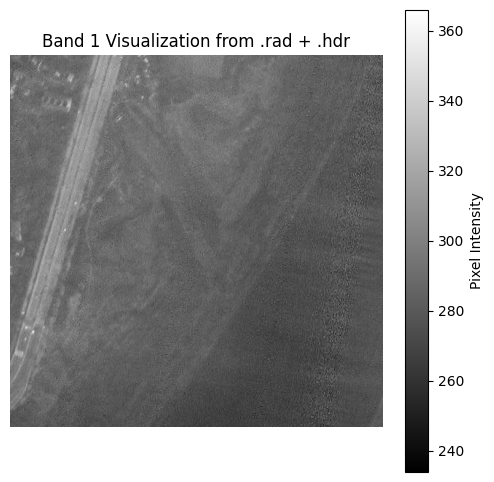

In [3]:
import spectral
import matplotlib.pyplot as plt
import numpy as np
import os

# Set your file path
hdr_path = "/content/band1_image3.rad.hdr"

# Load the image using Spectral
image = spectral.open_image(hdr_path).load()

# Convert to NumPy array for processing
image_np = np.array(image)

# Plot using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(image_np, cmap='gray')
plt.colorbar(label="Pixel Intensity")
plt.title("Band 1 Visualization from .rad + .hdr")
plt.axis('off')
plt.show()


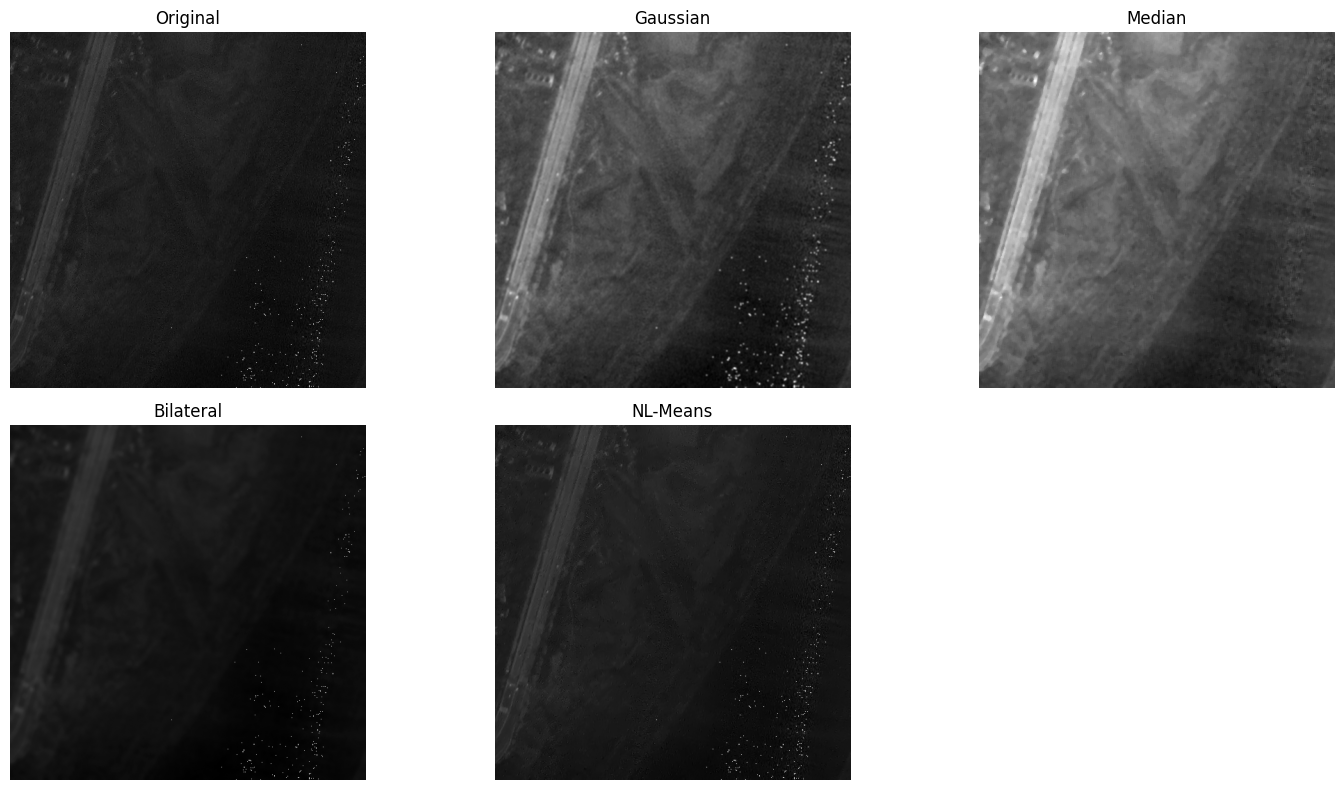

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.restoration import denoise_nl_means, estimate_sigma
from spectral import open_image

# Load image from .hdr file
img = open_image("/content/band1_image3.rad.hdr").load()
image_np = np.array(img).squeeze()  # Remove singleton dimensions if any
image_np = image_np.astype(np.uint8)

# Resize (optional for faster denoising) - Comment out if not needed
# image_np = cv2.resize(image_np, (256, 256))

# 1. Gaussian Blur
gaussian = cv2.GaussianBlur(image_np, (5, 5), 0)

# 2. Median Filter
median = cv2.medianBlur(image_np, 5)

# 3. Bilateral Filter
bilateral = cv2.bilateralFilter(image_np, 9, 75, 75)

# 4. Non-Local Means Denoising
image_float = image_np / 255.0
sigma_est = np.mean(estimate_sigma(image_float, channel_axis=None))
nlm = denoise_nl_means(image_float, h=1.15 * sigma_est, fast_mode=True,
                       patch_size=5, patch_distance=6, channel_axis=None)
nlm = (nlm * 255).astype(np.uint8)

# 🔍 Visualization
titles = ['Original', 'Gaussian', 'Median', 'Bilateral', 'NL-Means']
images = [image_np, gaussian, median, bilateral, nlm]

plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [7]:
from skimage.metrics import peak_signal_noise_ratio as psnr

# Function to calculate PSNR
def calculate_psnr(original, denoised):
    return psnr(original, denoised, data_range=255)

# Calculate PSNR values
psnr_gaussian = calculate_psnr(image_np, gaussian)
psnr_median = calculate_psnr(image_np, median)
psnr_bilateral = calculate_psnr(image_np, bilateral)
psnr_nlm = calculate_psnr(image_np, nlm)

# Store in dictionary
psnr_scores = {
    "Gaussian": psnr_gaussian,
    "Median": psnr_median,
    "Bilateral": psnr_bilateral,
    "NL-Means": psnr_nlm
}

# Print PSNR values
for method, score in psnr_scores.items():
    print(f"{method} PSNR: {score:.2f} dB")


Gaussian PSNR: 31.16 dB
Median PSNR: 29.90 dB
Bilateral PSNR: 35.29 dB
NL-Means PSNR: 45.10 dB


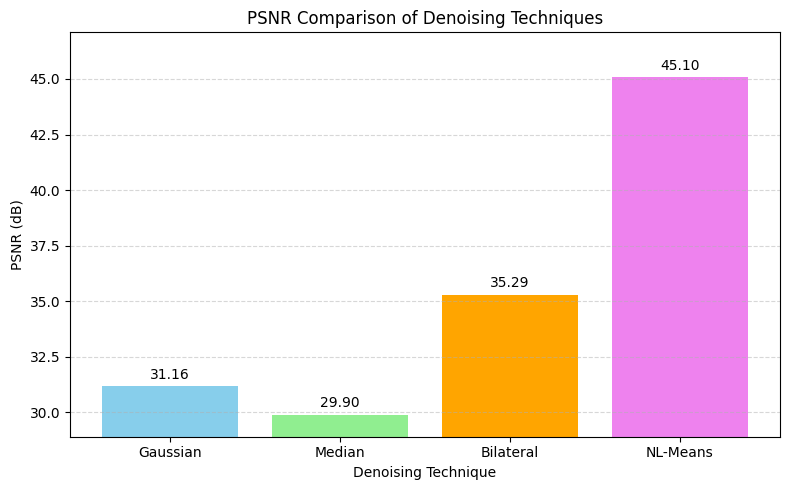

In [8]:
import matplotlib.pyplot as plt

# PSNR values dictionary (from previous step)
psnr_scores = {
    "Gaussian": psnr_gaussian,
    "Median": psnr_median,
    "Bilateral": psnr_bilateral,
    "NL-Means": psnr_nlm
}

# Plotting
plt.figure(figsize=(8, 5))
methods = list(psnr_scores.keys())
values = list(psnr_scores.values())

bars = plt.bar(methods, values, color=['skyblue', 'lightgreen', 'orange', 'violet'])
plt.xlabel("Denoising Technique")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Comparison of Denoising Techniques")
plt.ylim(min(values) - 1, max(values) + 2)

# Annotate bars with exact values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
